# Exploring Data Assimilation
Author: Luke Madaus < <luke.madaus@jupiterintel.com> > 24 Mar 2018

This notebook explores how ensemble-based data assimilation works to spread the information from observations to update an entire global atmospheric state.

It uses the GEFS ensemble data available from the UCAR THREDDS server as an example ensemble system.

Concepts covered:
 - Getting ensemble data from a THREDDS server
 - Exploring how covariances, correlations, and regressions are related and are used to spread observation information
 - Data assimilation methods (e.g. localization) for overcoming ensemble sampling error
 - An implementation of the ensemble Kalman Filter
 - How observation error and ensemble "spread" work to estimate the impact of an observation
 

Let's start by importing some useful libraries.

In [34]:
import xarray
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import cartopy
from cartopy.util import add_cyclic_point

## Loading ensemble data
Here we're going to connect to a "THREDDS" server at NCAR/UCAR that hosts operational model analyses, forecasts and observations.  For this demonstration of ensemble data assimilation, we need an ensemble.  We'll connect to the "Best" GEFS ensemble forecast ("Best" meaning "most recent") using xarray.

In [35]:
gefs_thredds = 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/Best'
dset = xarray.open_dataset(gefs_thredds)
dset

<xarray.Dataset>
Dimensions:                                                              (depth_below_surface_layer: 1, depth_below_surface_layer_bounds_1: 2, ens: 21, height_above_ground: 1, height_above_ground1: 1, isobaric: 1, isobaric1: 12, isobaric2: 10, isobaric3: 11, lat: 181, lon: 360, pressure_difference_layer: 1, pressure_difference_layer_bounds_1: 2, time: 124, time1: 187, time2: 186, time2_bounds_1: 2)
Coordinates:
  * lat                                                                  (lat) float32 90.0 ... -90.0
  * lon                                                                  (lon) float32 0.0 ... 359.0
  * time                                                                 (time) datetime64[ns] 2019-03-25 ... 2019-05-03
    reftime                                                              (time) datetime64[ns] ...
  * time1                                                                (time1) datetime64[ns] 2019-03-25 ... 2019-05-10T12:00:00
    reftime1  

We'll start by looking at 2m temperature in the ensemble.  The name of this variable in the dataset is "Temperature_height_above_ground_ens".  Let's get the 24-hour forecast as our background, first-guess ensemble forecast.

In [36]:
variable = 'Temperature_height_above_ground_ens'
vardata = dset[variable]
# Let's get the 24-hour forecast from all ensemble members
# And, in this case, also grab the 2m level (it's the only level, but you still have to tell xarray to grab it)
try:
    fcst_24 = vardata['time'][0] + np.timedelta64(24,'h')
    vardata = vardata.loc[dict(time=fcst_24, height_above_ground=2.0)]
except KeyError:
    fcst_24 = vardata['time1'][0] + np.timedelta64(24,'h')
    vardata = vardata.loc[dict(time1=fcst_24, height_above_ground=2.0)]
    
vardata

<xarray.DataArray 'Temperature_height_above_ground_ens' (ens: 21, lat: 181, lon: 360)>
[1368360 values with dtype=float32]
Coordinates:
  * lat                  (lat) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * lon                  (lon) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    time1                datetime64[ns] 2019-03-26
    reftime1             datetime64[ns] ...
    height_above_ground  float32 2.0
  * ens                  (ens) int32 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19 20
Attributes:
    long_name:                      Temperature @ Specified height level abov...
    units:                          K
    abbreviation:                   TMP
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-0-0_L103
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_T

Alternatively, change the cell below to "code" to instead get the 500 hPa temperatures.

This line below forces xarray to actually download the data from the THREDDS server.  It should be pretty quick.  Note the dimensions of the array---number of ensemble members (21), latitudes and longitudes

In [37]:
# Actually load the data from the THREDDS server here
vardata.load()

<xarray.DataArray 'Temperature_height_above_ground_ens' (ens: 21, lat: 181, lon: 360)>
array([[[239.2, 239.2, ..., 239.2, 239.2],
        [238.1, 238.2, ..., 238. , 238. ],
        ...,
        [230.5, 230.5, ..., 230.4, 230.5],
        [229.7, 229.7, ..., 229.7, 229.7]],

       [[239.3, 239.3, ..., 239.3, 239.3],
        [238.1, 238.2, ..., 238. , 238. ],
        ...,
        [232.3, 232.3, ..., 232.3, 232.3],
        [230.8, 230.8, ..., 230.8, 230.8]],

       ...,

       [[238.9, 238.9, ..., 238.9, 238.9],
        [237.9, 238. , ..., 237.9, 237.9],
        ...,
        [228.5, 228.5, ..., 228.6, 228.6],
        [227.8, 227.8, ..., 227.8, 227.8]],

       [[237.9, 237.9, ..., 237.9, 237.9],
        [236.4, 236.5, ..., 236.2, 236.3],
        ...,
        [229.6, 229.6, ..., 229.6, 229.6],
        [229.7, 229.7, ..., 229.7, 229.7]]], dtype=float32)
Coordinates:
  * lat                  (lat) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * lon                  (lon) float32 0.0 

## Ensemble covariances and correlations
Most modern data assimilation relies on having estimates of the *covariance* between how an observation changes the estimate of the state at a given point and how the state should change across all other points and variables in response.

In this demonstration of ensemble data assimilation, we'll use the ensemble to estimate the covariances.  We start by splitting the ensemble data into two arrays: the ensemble mean, and the perturbations of each ensemble member away from that mean.

In [38]:
# Calculate the ensemble mean and perturbations
ens_mean = vardata.mean(dim='ens')
ens_pert = vardata - ens_mean

Let's take a quick look at a map of the ensemble mean temperature

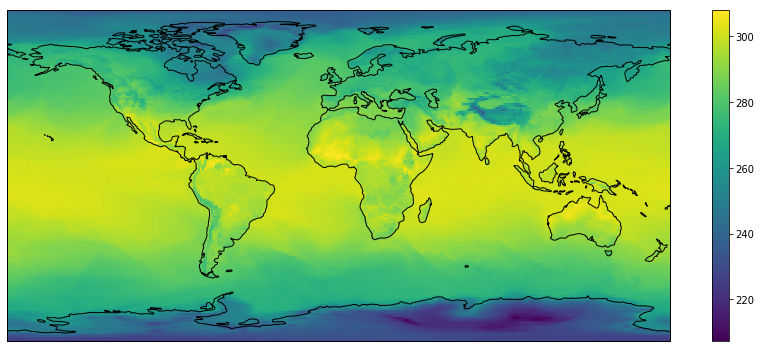

In [39]:
proj = cartopy.crs.PlateCarree()
plt.figure(figsize=(12,5))
ax = plt.axes(projection=proj)
plotme,lonplot=add_cyclic_point(ens_mean.values,coord=vardata['lon'].values)
meanplt = ax.pcolormesh(lonplot, vardata['lat'], plotme, transform=proj)
ax.coastlines()
plt.colorbar(meanplt)
plt.tight_layout()
plt.show()

Now, we'll imagine we have a single observation of 2m temperature at some latitude and longitude.  What kind of impact will assimilating this observation have on the ensemble estimate of the 2m temperature state? We can estimate this by looking at the covariance and correlation between the ensemble estimate of the observation and the ensemble estimate at all other points.

We start by simply selecting the ensemble perturbations at the grid point closest to the latitude and longitude of our observation.

In [66]:
# Denver
#ob_lat = 39.7392
#ob_lon = 360-104.9903 # Put it in 0-360 space
# Paris
#ob_lat = 48.8566
#ob_lon = 2.3522
# Reykjavik
ob_lat = 64.1466
ob_lon = 360-21.9426
#ob_lat = -33.8688
#ob_lon = 151.2
# Get the perturbation values close to it
ob_estimate_pert = ens_pert.sel(lat=ob_lat, lon=ob_lon, method='nearest')
ob_estimate_pert

<xarray.DataArray 'Temperature_height_above_ground_ens' (ens: 21)>
array([ 0.042847, -0.257141, -0.057159,  0.042847,  0.142853, -0.157166,
       -0.057159, -0.157166,  0.042847,  0.042847, -0.057159,  0.042847,
        0.042847,  0.042847, -0.157166,  0.142853,  0.042847,  0.142853,
        0.042847, -0.057159,  0.142853], dtype=float32)
Coordinates:
    lat                  float32 64.0
    lon                  float32 338.0
    time1                datetime64[ns] 2019-03-26
    reftime1             datetime64[ns] 2019-03-26
    height_above_ground  float32 2.0
  * ens                  (ens) int32 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19 20

In data assimilation, what we really want are the *covariances* between 2m temperature at the location of the observation to all other points.  This is like doing a really big least-squares regression between the observation estimate and the estimate at all other points.

For instance, what if we compute the correlation and covariance between the ensemble estimate of the observation and the ensemble data at a nearby gridpoint?

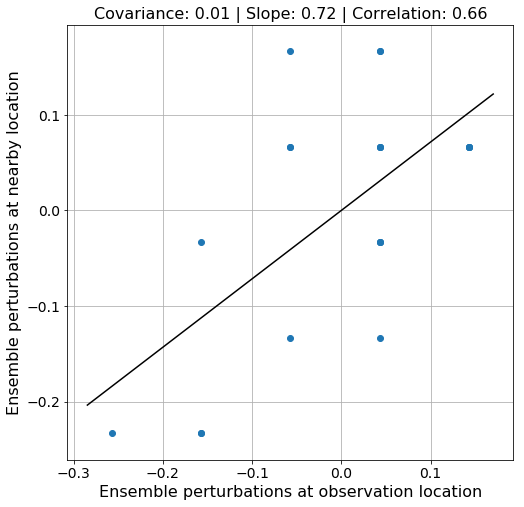

In [67]:
# Get ensemble estimate at a nearby gridpoint
ob_lat_nearby = ob_lat - 1.0
ob_lon_nearby = ob_lon + 1.0
ob_estimate_pert_nearby = ens_pert.sel(lat=ob_lat_nearby, lon=ob_lon_nearby, method='nearest')

# Compute the covariance and correlation
# Need to know how many ensemble members for this calculation...
nens, ny, nx = ens_pert.shape
# Here is the covariance calculation
nearby_covariance = float((ob_estimate_pert * ob_estimate_pert_nearby).sum(dim='ens') / (nens - 1))
# Correlation is just the covariance normalized by the product of the standard deviations
nearby_correlation = float(nearby_covariance / (ob_estimate_pert.std(dim='ens') * ob_estimate_pert_nearby.std(dim='ens')))

# Make a plot of this to see...plot the perturbations at the observation location vs perturbations at the nearby point
plt.figure(figsize=(8,8))
plt.scatter(ob_estimate_pert.values, ob_estimate_pert_nearby.values)
plt.xlabel('Ensemble perturbations at observation location', fontsize=16)
plt.ylabel('Ensemble perturbations at nearby location', fontsize=16)
# This is the powerful bit ... the covariance divided by the variance in the
# estimate of the observation is the slope of the linear
# regression (least-squares fit) between the two datasets
# y = covariance / variance * x
# (Intercept is zero because we calculated this from perturbations...ensemble mean is removed)
# Plot a line showing this
# Make the line span the data
xmin, xmax = plt.xlim()
# Here we caluclate the slope as the covariance divided by the variance in the estimate of the observation
slope = float(nearby_covariance / (ob_estimate_pert.var(ddof=1)))
plt.plot([xmin,xmax],[slope*xmin, slope*xmax], c='k')
# Mention the covariance, slope and correlation in the title
plt.title(f'Covariance: {nearby_covariance:3.2f} | Slope: {slope:3.2f} | Correlation: {nearby_correlation:3.2f}', fontsize=16)
plt.grid()
# Trick here to make the tick labels bigger
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

We can see that there is a good linear relationship between temperature perturbations at the location of our observations and a nearby point, as estimated by our ensemble.  This is powerful!  It suggests to us that if an observation "bumps" the temperature a little bit, we should also "bump" the temperature at the nearby point as well.

What about a more distant point?

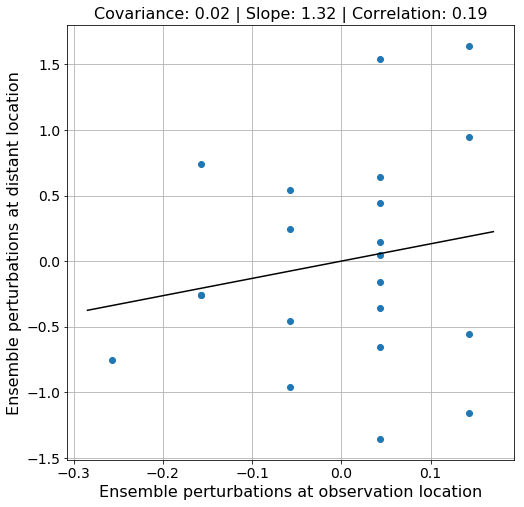

In [68]:
# Get ensemble estimate at a distant gridpoint
# Don't go beyond the range of lats/lons though
ob_lat_distant = ob_lat + 20
ob_lon_distant = ob_lon + 20
ob_estimate_pert_distant = ens_pert.sel(lat=ob_lat_distant, lon=ob_lon_distant, method='nearest')

# Compute the covariance and correlation
# Need to know how many ensemble members for this calculation...
nens, ny, nx = ens_pert.shape
# Here is the covariance calculation
distant_covariance = float((ob_estimate_pert * ob_estimate_pert_distant).sum(dim='ens') / (nens - 1))
# Correlation is just the covariance normalized by the product of the standard deviations
distant_correlation = float(distant_covariance / (ob_estimate_pert.std(dim='ens') * ob_estimate_pert_distant.std(dim='ens')))

# Make a plot of this to see
plt.figure(figsize=(8,8))
plt.scatter(ob_estimate_pert.values, ob_estimate_pert_distant.values)
plt.xlabel('Ensemble perturbations at observation location', fontsize=16)
plt.ylabel('Ensemble perturbations at distant location', fontsize=16)
# This is the powerful bit ... the covariance divided by the variance in the
# estimate of the observation is the slope of the linear
# regression (least-squares fit) between the two datasets
# y = covariance / variance * x
# (Intercept is zero because we calculated this from perturbations...ensemble mean is removed)
# Plot a line showing this
xmin, xmax = plt.xlim()
slope = float(distant_covariance / (ob_estimate_pert.var(ddof=1)))
plt.plot([xmin,xmax],[slope*xmin, slope*xmax], c='k')
# Mention the covariance, slope and correlation in the title
plt.title(f'Covariance: {distant_covariance:3.2f} | Slope: {slope:3.2f} | Correlation: {distant_correlation:3.2f}', fontsize=16)
plt.grid()
# Trick here to make the tick labels bigger
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

We see here the relationship is much weaker...the correlation coefficient is smaller as is the covariance.  This makes sense...we don't expect that changing the 2m temperature at one point should have a strong impact at a large distance away.

Let's now compute the correlation of our observation to *all other points* in the domain...

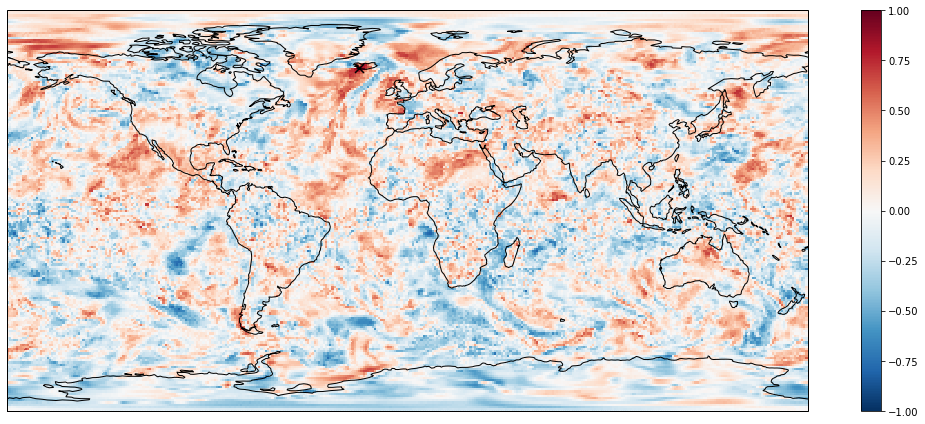

In [69]:
# Now, compute the correlation to all other points
ob_covariance = (ob_estimate_pert * ens_pert).sum(dim='ens') / (nens - 1)
ob_correlation = ob_covariance / (ob_estimate_pert.std(dim='ens') * ens_pert.std(dim='ens'))

# Make a map of this
plt.figure(figsize=(15,6))
ax = plt.axes(projection=proj)
# Cyclic point addition
plotme,lonplot=add_cyclic_point(ob_correlation.values,coord=vardata['lon'].values)
corrplt = ax.pcolormesh(lonplot, vardata['lat'], plotme, transform=proj, vmin=-1, vmax=1, cmap=matplotlib.cm.RdBu_r)
# Remind us where our observation was
# by making an "x" there
ax.scatter([ob_lon], [ob_lat], transform=proj, marker='x', facecolor='k', s=80)
ax.coastlines()
plt.colorbar(corrplt)
plt.tight_layout()
plt.show()

Note that the correlations are very high close to our observation and do *generally* decrease moving away from it.

But they don't go to zero at large distances!  We see a lot of noise in there...strong positive or negative correlations all over the globe!  Why is this?

It has to do with *sampling error*...a fundamental problem in ensemble data assimilation.  The GEFS only has 21 ensemble members, but we have 181 x 360 = 65160 grid points we are correlating to. With so few ensemble members, we get lots of points with "spurious" large correlations. If we didn't do something about this, then when we assimilated our observation, it would change the estimate of the surface temperature far away from the observation location...even on the opposite side of the globe...something we know isn't likely to be physically realistic.  So what to do? 

We could try and solve this by getting more ensemble members, but we'd need *hundreds* to *thousands* of ensemble members to really ensure we weren't getting a lot of spurious correlations.  That's a lot of additional computational need to generate those members.

Let's explore another way...


## Localization
A common technique in data assimilation is to *localize* the covariances to help eliminate this problem.  We manually force the covariances to go to zero at a certain distance away from the observation.

The function below is designed to do that.  It takes the array of covariances between the observation location and all other points, computes the distances from the observation to all other points, and then applys weights to "dampen" the covariances down to zero at a certain radius.  The function used to calculate those weights here is called the *Gaspari-Cohn* function, which is commonly used in data assimilation.  It's a lot like a Gaussian curve, but is forced to go to zero at a certain distance.

In [44]:
def localize(cov, target_lat, target_lon, loc_radius=10, field_lat=vardata['lat'].values, field_lon=vardata['lon'].values):
    """
    Uses the Gaspari-Cohn function to localize the covariance within loc_radius (Degrees)
    of the target_lat, target_lon point
    
    NOTE: in the Gaspari-Cohn formulation, "loc_radius" is actually the "half-width" of the weight curve.
    Weights actually go to zero at twice the loc_radius.
    """
    # First, calculate the distance to all points
    # Build 2d fields of longitude and latitude
    lon_grid, lat_grid = np.meshgrid(field_lon, field_lat)
    # An array of distances (in units of degrees)
    lon_diff = np.abs(target_lon - lon_grid)
    lon_diff[lon_diff > 180] = 360 - lon_diff[lon_diff > 180]
    # Reset longitude differences across prime meridian
    distances = np.hypot(lon_diff, target_lat-lat_grid)
    # Now make r, which is the distance length relative to loc_radius
    # At the localization radius, r will be 1
    r = distances / loc_radius
    # Make an array of zeros to hold the localization weights
    weights = np.zeros(cov.shape)
    # This is the Gaspari-Cohn function commonly used in data assimilation
    # It is a piecewise function with different forms for r in (1,2) and r < 1.
    # For r > 2, it is zero
    # Start by finding all points between 1 and 2
    rmask = np.bitwise_and(r <= 2, r > 1)
    # Apply the function to those points
    weights[rmask] = ( ( ( ( r[rmask]/12.0 -0.5 )*r[rmask] +0.625 )*r[rmask] +5.0/3.0 )*r[rmask] -5.0 )*r[rmask] + 4.0 - 2.0 / (3.0 * r[rmask])
    # Now for all r <= 1 (it will be left zero everywhere else)
    weights[r <= 1] = ( ( ( -0.25*r[r<=1] +0.5 )*r[r<=1] +0.625 )*r[r<=1] -5.0/3.0 )*r[r<=1]**2 + 1.0
    # Apply these weights to the covariance
    output = cov * weights
    # Return this
    return output

Let's plot the correlation maps, same as before, but *localize* the covariance first using our function above.

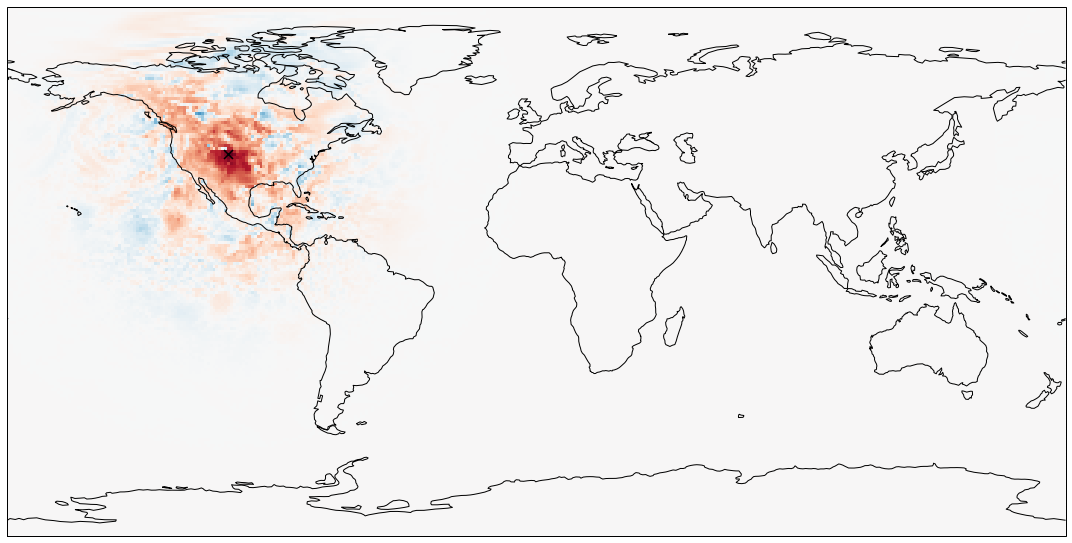

In [45]:
# Now, same exercise, but localize the covariance
localization_radius = 50 # degrees  Change this here to see what happens!
ob_covariance = (ob_estimate_pert * ens_pert).sum(dim='ens') / (nens - 1)
# Localize here!
ob_covariance = localize(ob_covariance, ob_lat, ob_lon, loc_radius=localization_radius)
# Calculate the correlation on the localized covariance
ob_correlation = ob_covariance / (ob_estimate_pert.std(dim='ens') * ens_pert.std(dim='ens'))
plt.figure(figsize=(15,10))
ax = plt.axes(projection=proj)
plotme,lonplot=add_cyclic_point(ob_correlation.values,coord=vardata['lon'].values)
ax.pcolormesh(lonplot, vardata['lat'], plotme, transform=proj, vmin=-1, vmax=1, cmap=matplotlib.cm.RdBu_r)
# Remind us where our observation was
ax.scatter([ob_lon], [ob_lat], transform=proj, marker='x', facecolor='k', s=80)
ax.coastlines()
plt.tight_layout()
plt.show()

You can see now that if we assimilated the observation with these localized covariances, we would only be able to adjust the ensemble state in a relatively small area surrounding our observation.  A lot fewer distant, "spurious" updates!

#### QUESTIONS TO THINK ABOUT:
=========================
 - How do we determine the best localization radius to use?  Will it be the same every time we want to assimilate observations?
 - Do we expect the best localization radius to be the same for all variables?  Try going through the above cells again, but choosing a different variable from the GEFS ensemble like the 500 hPa temperature.
 - More challenging: do we need to do localization if we were using a "fixed" or "climo" covariance matrix instead of an ensemble? Why or why not?
 
## Assimilation with the Ensemble Kalman Filter

We're going to use the ensemble Kalman filter equations to assimilate observations and see how they adjust the state.  There are many "flavors" of Kalman filters, here we'll use a flavor called the "square root filter".

Remember we've separated our (background) ensemble state into an ensemble mean ($\overline{x_b}$) and ensemble member perturbations from the mean ($X'_b$).  We update both separately.

This is the update equation in the Kalman Filter for the ensemble mean:

$\overline{x_a} = \overline{x_b} + K (y-H\overline{x_b})$

Where:
 - $\overline{x_a}$ is our final (analysis/posterior) ensemble mean state
 - $\overline{x_b}$ is our initial (background/prior) ensemble mean state
 - $y$ is the observation value
 - $H$ is an operator that just says "interpolate to or estimate the observation from the ensemble"
 - $K$ is the Kalman Gain, computed as:

$K = BH^{T}[HBH^{T} + R]^{-1}$

Where:
 - $B$ is the *background error covariance* -- the covariance to all other points.
   Functionally in the 'square-root filter' form, B is calculated as $B = \frac{1}{\sqrt{N_{ens}-1}}X'_b {X'_b}^{T} $
 - $R$ is the *observation error covariance* -- here, this is just the observation error (expressed as a variance)

We also update the ensemble perturbations from the mean with this equation:

$X'_a = [I - \beta KH]X'_b $

Where $I$ is the identity matrix (or, for a single observation, "1")
and $\beta$ is a "square root" weighting factor that reduces sampling error when we assimilate the observations.

$\beta = {[1.0 + {(R[HBH^{T} + R]^{-1})}^{\frac{1}{2}}]}^{-1}$



The function below will do the ensemble Kalman Filter update.  It takes our background ensemble mean, background ensemble perturbations, and a list of observations to assimilate (with an optional localization radius) and assimilates them, returning an "analysis" ensemble mean and perturbations.

In [26]:
def kalman_filter_update(ensemble_mean, ensemble_pert, observations, localization_radius=None, inflation=None):
    """
    Function to sequentially assimilate observations using an Ensemble Kalman (Square Root) filter
    The "square root" factor is required when calculating the covariances and updating the ensemble spread
    """
    # Find how many ensemble members
    nens = ensemble_mean.shape[0]
    # Set our state here
    # Copy here to be sure our posterior states are separate
    post_mean = ensemble_mean.copy()
    post_pert = ensemble_pert.copy()
    prior_mean = ensemble_mean.copy()
    prior_pert = ensemble_pert.copy()
    if inflation is not None:
        post_pert.values = post_pert.values * np.sqrt(inflation)
    # For this particular implementation, loop through all the observations
    for ob in observations:
        print("Assimilating observation:", ob['lat'], ob['lon'])
        # Start over making the old posterior state the new prior state
        prior_mean.values = post_mean.values
        prior_pert.values = post_pert.values
        # Get the ensemble estimate of this observation, both the mean value and the perturbation
        ob_estimate_mean = prior_mean.sel(lat=ob['lat'], lon=ob['lon'], method='nearest')
        ob_estimate_pert = prior_pert.sel(lat=ob['lat'], lon=ob['lon'], method='nearest')
        print("   Ob estimate variance before inflation:", float(ensemble_pert.sel(lat=ob['lat'], lon=ob['lon'], method='nearest').var(ddof=1)))
        print("   Ob estimate variance after inflation :", float(ob_estimate_pert.var(ddof=1)))
        print("   Observation error variance:", ob['error'])
        # Now get the "innovation" y-HXb (observation value minus the ensemble mean estimate of the observation)
        innovation = ob['value'] - float(ob_estimate_mean)
        print("   Ob value:", float(ob['value']))
        print("   Innovation (ob_value - ob_estimate):", innovation)
        # Start building the Kalman Gain
        # First term in Kalman Gain is BHt -> The covariance of the ensemble estimate of the observation
        # to all other points.  When computing covariances, we always want the mean removed, so use ob_ensemble_pert
        # and ensemble_pert
        BHt_covariance = (ob_estimate_pert * prior_pert).sum(dim='ens') / (nens - 1)
        # Localize it here if we requested it
        if localization_radius is not None:
            BHt_covariance = localize(BHt_covariance, ob['lat'], ob['lon'], loc_radius=localization_radius)
        # Second term of the Kalman gain is (HBHt) -> The variance in the ensemble estimate of the observation
        # ddof=1 should normalize with "delta-degrees-of-freedom" being 1
        HBHt_estimate_variance = float((ob_estimate_pert**2).sum(dim='ens') / (nens-1))
        # Can now build the Kalman gain (BHt * [HBHt + R]^-1) with "R" being the observation error
        K = BHt_covariance / (HBHt_estimate_variance + ob['error'])
        # Update the ensemble mean now using the Kalman Filter equation
        post_mean = prior_mean + K * innovation
        ob_estimate_post = float(post_mean.sel(lat=ob['lat'], lon=ob['lon'], method='nearest'))
        print("   Ob estimate prior:", float(ob_estimate_mean))
        print("   Ob estimate post:", ob_estimate_post)
        print("   Increment (post-prior):",  float(ob_estimate_post - ob_estimate_mean))
        # To update the ensemble perturbations, we need to account for sampling error with our small ensemble
        # There are many ways to do this; here we just use a "Square root factor" beta
        beta = 1.0 / (1.0 + np.sqrt(ob['error'] / (HBHt_estimate_variance + ob['error'])))
        post_pert = prior_pert - (beta * K * ob_estimate_pert)
        #print((post_pert - prior_pert).mean())
        #post_pert = prior_pert
    
    # Now that we've looped through the observations, return the posterior state
    return post_mean, post_pert
    

So let's try using this to assimilate some observations.  We assimilate them one at a time, looping through and applying the equations above.  In this way, we don't have to think of these as matrices since we only ever have one observation to deal with.


First thing's first:  let's get some observations.  We're going to make up a value for a single observation.

In [27]:
# List of observations
print(ens_mean.sel(lat=ob_lat, lon=ob_lon, method='nearest'))
obs = []
obs.append({'lat':ob_lat, 'lon':ob_lon, 'value': 290.0, 'error':1.0})

<xarray.DataArray 'Temperature_height_above_ground_ens' ()>
array(285.0619, dtype=float32)
Coordinates:
    lat                  float32 40.0
    lon                  float32 255.0
    time1                datetime64[ns] 2019-03-26
    reftime1             datetime64[ns] 2019-03-26
    height_above_ground  float32 2.0


Let's use the function to do the assimilation.  We can try changing the localization radius and the observation error here to see what that does. (We'll look at "inflation" later...leave it at 1.0 for now).

In [28]:
# SET PARAMETERS HERE
loc_radius = None # degrees.  Set to None to not localize
inflation = 1.0 # Leave at 1.0 for no inflation
obs_error = 1.0
nobs_to_assimilate = 'all' # 'all' will assimilate all observations

# DON'T CHANGE THESE TWO LINES: they apply your settings from above
for x in obs:
    x['error'] = obs_error
if nobs_to_assimilate is not 'all':
    use_obs = obs[:nobs_to_assimilate]
else:
    use_obs = obs

posterior_mean, posterior_pert = kalman_filter_update(ens_mean, ens_pert, use_obs, localization_radius=loc_radius, inflation=inflation)

Assimilating observation: 39.7392 255.0097
   Ob estimate variance before inflation: 0.37347692251205444
   Ob estimate variance after inflation : 0.37347692251205444
   Observation error variance: 1.0
   Ob value: 290.0
   Innovation (ob_value - ob_estimate): 4.9381103515625
   Ob estimate prior: 285.0618896484375
   Ob estimate post: 285.2586364746094
   Increment (post-prior): 0.196746826171875


We printed out a lot of statistics along the way for what the Kalman filter was doing.

Compare the "Innovation" value (the observation value minus the ensemble estimate of the observation) to the "Increment" (how much the ensemble estimate actually changed after the assimilation). Notice that the actual adjustment we ended up making (increment) was smaller in magnitude than the actual difference between the observation and the ensemble estimate of the observation (the innovation).  Why was this? Why didn't the observation have a greater impact?

When the Kalman filter goes to use the covariances to figure out how far to bump the ensemble mean, it doesn't bump it the full way (the full innovation).  Instead, it takes a *weighted average* of the ensemble estimate of the observation and the observation value. Where do these weights come from?  The ensemble variance and the observation error variance.

In the statistics above, compare two numbers: the "Ob estimate variance before inflation" and the "Observation error variance".  The former is the ensemble variance in its estimate of the observation--in other words, how "certain" the ensemble is in its estimate of the value at the observation location.  The latter is the "error" or "uncertainty" in the observation value itself.

You'll see that the ensemble variance is much smaller than the observation error variance.  The Kalman filter sees this too...and it weights the ensemble estimate (the background/prior value) more heavily than the observation because the ensemble looks "more certain" than the observation value.  So the observation still bumped the estimate, but not a whole lot.

How do we get a bigger bang for our observational buck?  We can play with the weights.  One way is to *decrease* our observation error variance...that is, make us more confident in our observations.  Let's repeat the assimilation above, but make the observation error variance 10% of what it was:

In [29]:
# SET PARAMETERS HERE
loc_radius = None # degrees.  Set to None to not localize
inflation = 1.0 # Leave at 1.0 for no inflation
obs_error = 0.1 # NOTE WE HAVE CHANGED THIS HERE!
nobs_to_assimilate = 'all' # 'all' will assimilate all observations

# DON'T CHANGE THESE TWO LINES: they apply your settings from above
for x in obs:
    x['error'] = obs_error
if nobs_to_assimilate is not 'all':
    use_obs = obs[:nobs_to_assimilate]
else:
    use_obs = obs

posterior_mean, posterior_pert = kalman_filter_update(ens_mean, ens_pert, use_obs, localization_radius=loc_radius, inflation=inflation)

Assimilating observation: 39.7392 255.0097
   Ob estimate variance before inflation: 0.37347692251205444
   Ob estimate variance after inflation : 0.37347692251205444
   Observation error variance: 0.1
   Ob value: 290.0
   Innovation (ob_value - ob_estimate): 4.9381103515625
   Ob estimate prior: 285.0618896484375
   Ob estimate post: 286.5101013183594
   Increment (post-prior): 1.448211669921875


Look at the increment now...a much bigger impact!

But there could also be another problem...that ensemble variance seems very low.  This is a common problem with our ensembles...they often are *underspread* or *underdispersive*.  That is, the spread between different ensemble members is lower than it should be given the true error in the model forecasts.  In data assimilation we can "fix" this by *inflating* the ensemble...just take the ensemble perturbations and multiply them by some factor.  Let's try "inflating" our ensemble (after resetting our observation error to 1.0) and see what happens.

In [30]:
# SET PARAMETERS HERE
loc_radius = None # degrees.  Set to None to not localize
inflation = 2.0 # DOUBLE THE ENSEMBLE VARIANCE
obs_error = 1.0 # This is back to 1.0
nobs_to_assimilate = 'all' # 'all' will assimilate all observations

# DON'T CHANGE THESE TWO LINES: they apply your settings from above
for x in obs:
    x['error'] = obs_error
if nobs_to_assimilate is not 'all':
    use_obs = obs[:nobs_to_assimilate]
else:
    use_obs = obs

posterior_mean, posterior_pert = kalman_filter_update(ens_mean, ens_pert, use_obs, localization_radius=loc_radius, inflation=inflation)

Assimilating observation: 39.7392 255.0097
   Ob estimate variance before inflation: 0.37347692251205444
   Ob estimate variance after inflation : 0.7469538450241089
   Observation error variance: 1.0
   Ob value: 290.0
   Innovation (ob_value - ob_estimate): 4.9381103515625
   Ob estimate prior: 285.0618896484375
   Ob estimate post: 285.4403076171875
   Increment (post-prior): 0.37841796875


You can see that the "Ob estimate variance" is doubled after inflation, and this, too, results in a larger increment.  Again, by increasing the  ensemble variance we imply the ensemble is "less certain", and we don't weight it as strongly.

Let's see what our assimilation did spatially.  We'll make a map of the *assimilation increment*, which is just the analysis (posterior) state minus the background (prior) state.  How did assimilating the observations change the state?

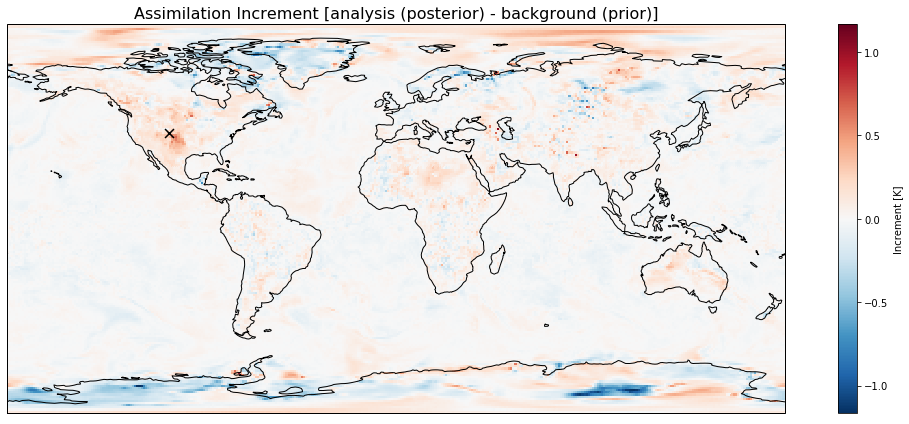

In [31]:
plt.figure(figsize=(15,6))
ax = plt.axes(projection=proj)
# Compute the increment in the ensemble mean
increment = posterior_mean - ens_mean
# Figure out how to scale the colorbar
maxval = max(abs(float(increment.min())), abs(float(increment.max())))
# Add cyclic point
plotme,lonplot=add_cyclic_point(increment.values,coord=vardata['lon'].values)
incplot = ax.pcolormesh(lonplot, vardata['lat'], plotme, transform=proj, vmin=-maxval, vmax=maxval, cmap=matplotlib.cm.RdBu_r)
# Remind us where our observations were
ax.scatter([x['lon'] for x in obs], [x['lat'] for x in obs], transform=proj, marker='x', facecolor='k', s=80)
ax.coastlines()
plt.title('Assimilation Increment [analysis (posterior) - background (prior)]', fontsize=16)
plt.colorbar(incplot, label='Increment [K]')
plt.tight_layout()
plt.show()

Notice we didn't apply localization to the above assimilation and look what happened... at our observation location, those *spurious* covariances made large adjustments in strange places...like Antarctica!

Trying to figure out how to properly estimate and balance these things...the localization, the inflation, the observation error...is a big part of doing data assimilation correctly.

### Variance changes in the Kalman filter
We've focused so far on the update to the mean state given by the Kalman filter.  What about the change to the ensemble perturbations?

Let's redo the assimilation here *without* applying inflation (as that will "artificially" change the ensemble perturbations).  Let's compare the variance in the ensemble members at all gridpoints before and after the assimilation.

In [32]:
# SET PARAMETERS HERE
loc_radius = None # degrees.  Set to None to not localize
inflation = 1.0 # No inflation (everything is multiplied by 1)
obs_error = 1.0 # K ** 2
nobs_to_assimilate = 'all' # 'all' will assimilate all observations

# DON'T CHANGE THESE TWO LINES: they apply your settings from above
for x in obs:
    x['error'] = obs_error
if nobs_to_assimilate is not 'all':
    use_obs = obs[:nobs_to_assimilate]
else:
    use_obs = obs

posterior_mean, posterior_pert = kalman_filter_update(ens_mean, ens_pert, use_obs, localization_radius=loc_radius, inflation=inflation)

Assimilating observation: 39.7392 255.0097
   Ob estimate variance before inflation: 0.37347692251205444
   Ob estimate variance after inflation : 0.37347692251205444
   Observation error variance: 1.0
   Ob value: 290.0
   Innovation (ob_value - ob_estimate): 4.9381103515625
   Ob estimate prior: 285.0618896484375
   Ob estimate post: 285.2586364746094
   Increment (post-prior): 0.196746826171875


We'll make a map of the change in variance from the original ensemble perturbations to the updated perturbations everywhere.

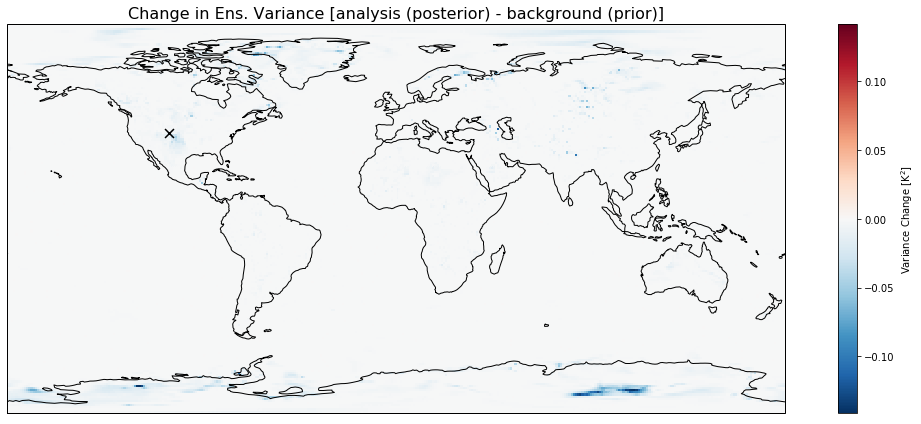

In [33]:
plt.figure(figsize=(15,6))
ax = plt.axes(projection=proj)
# What was the change in variance?
# Variance before assimilation.  Just to be safe, we'll apply the same "inflation" here
# in case you change that parameter...
variance_prior = ens_pert.var(dim='ens', ddof=1) * inflation
# Variance after assimilation 
variance_post = posterior_pert.var(dim='ens', ddof=1)
# How did it change?
variance_change = variance_post - variance_prior
# Figure out how to scale the colorbar
maxval = max(abs(float(variance_change.min())), abs(float(variance_change.max())))
# Build the plot
plotme,lonplot=add_cyclic_point(variance_change.values,coord=vardata['lon'].values)
incplot = ax.pcolormesh(lonplot, vardata['lat'], variance_change, vmin=-maxval, vmax=maxval, transform=proj, cmap=matplotlib.cm.RdBu_r)
# Remind us where our observations were
ax.scatter([x['lon'] for x in obs], [x['lat'] for x in obs], transform=proj, marker='x', facecolor='k', s=80)
ax.coastlines()
plt.title('Change in Ens. Variance [analysis (posterior) - background (prior)]', fontsize=16)
plt.colorbar(incplot, label='Variance Change [K$^2$]')
plt.tight_layout()
plt.show()

Notice that the variance change was negative everywhere...that is, the ensemble variance was reduced at all points.

This is actually *guaranteed* by the Kalman filter equations...every observation assimilated will reduce the variance everywhere it has an impact.  The theory behind this is that the observation contributes additional information to the ensemble, so the ensemble should become *more certain* of the values with this additional information.

#### QUESTIONS TO CONSIDER
=======================
- Try changing the localization radius, making it really small (e.g., 2 deg), pretty big (e.g., 50 deg) or completely turning it off (loc_radius=None).  How does that change the increment, particularly far away from your observations? How does that change the ensemble variance?
- Think about what happens if you assimilate multiple observations.  As we said above, each observation you assimilate is *guaranteed* to decrease the ensemble variance wherever the observation has an impact.  What does that mean for the weight the Kalman filter gives to the ensemble estimate versus the observation values over time?  
- How might you decide which observations to assimilate to maximize the impact?